In [1]:
# facilitate imports from project root
import sys
sys.path.append("..")

In [2]:
import collections

import gpxpy
import overpy
import pyproj
import contextily as cx
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.geometry import LineString, Point
from shapely.ops import transform
from routingpy import OSRM, convert, utils

from chase_rank.way_categorizer import categorize_way

In [3]:
TEST_TRACK_PATH = "../data/routes/test_track.gpx"

BASEMAP_SOURCE = cx.providers.CartoDB.Positron

OSRM_CLIENT = OSRM(base_url="http://127.0.0.1:5000")
OVERPASS_API = overpy.Overpass()

---
# Datei Laden

In [4]:
with open(TEST_TRACK_PATH) as file_pointer:
    gpx_content = gpxpy.parse(file_pointer)

gpx_data = []
gpx_geometry = []
for point in gpx_content.tracks[0].segments[0].points:
    gpx_geometry.append(Point(point.longitude, point.latitude))
    gpx_data.append({
        # clear tzinfo until it can be handled for the match query
        "time": point.time.replace(tzinfo=None),
        "elev": point.elevation,
        "longitude": point.longitude,
        "latitude": point.latitude
    })

gpx_frame = gpd.GeoDataFrame(
    gpx_data, geometry=gpx_geometry, crs="EPSG:4326").to_crs("EPSG:3857")

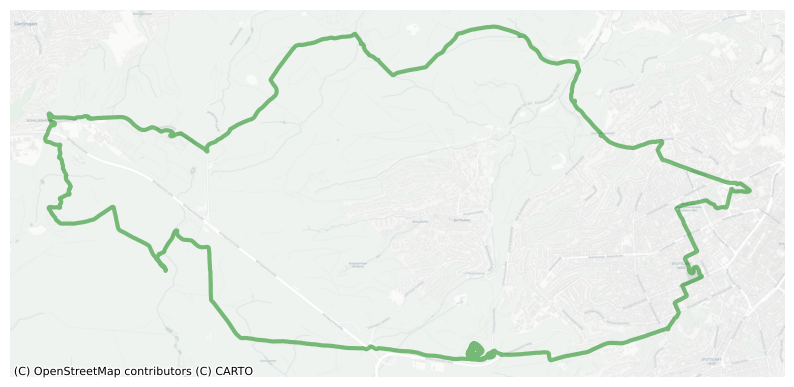

In [5]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
gpd.GeoDataFrame(geometry=[LineString(gpx_frame["geometry"])]).plot(
    ax=ax, color="green", linewidth=3, alpha=0.5)
cx.add_basemap(ax=ax, crs="EPSG:3857", source=BASEMAP_SOURCE)
_ = ax.axis("off")

---
# Matching & Overpass

In [14]:
((gpx_frame["time"] - pd.Timestamp("1970-01-01")) // pd.Timedelta("1s")).astype(str)

0       1664110046
1       1664110047
2       1664110048
3       1664110049
4       1664110050
           ...    
5643    1664116992
5644    1664116993
5645    1664116994
5646    1664116995
5647    1664116997
Name: time, Length: 5648, dtype: object

In [15]:
service = "match"
profile = "driving"
locations = gpx_frame[["longitude", "latitude"]].values.tolist()
coords = convert.delimit_list(
    [convert.delimit_list([convert.format_float(f) for f in pair]) for pair in locations], ";"
)
timestamps = ";".join(
    ((gpx_frame["time"] - pd.Timestamp("1970-01-01")) // pd.Timedelta("1s")).astype(str).values.tolist())

params = OSRM_CLIENT.get_direction_params(
    locations,
    profile,
    steps=True,
    geometries="polyline",
    overview="full",
    annotations="nodes",
    timestamps=timestamps
)

response = OSRM_CLIENT.client._request(
    f"/{service}/v1/{profile}/{coords}",
    get_params=params,
    dry_run=False
)

response["code"]

'Ok'

In [16]:
# most of the matchings and legs in the matchings share nodes
# to reduce the request to the overpass api we only want unique nodes
unique_nodes = {
    node
    for match in response["matchings"]
    for leg in match["legs"]
    for node in leg["annotation"]["nodes"]
}

# the request gets all the nodes by their ids
# then we recursively find all the ways that contain those nodes
result = OVERPASS_API.query(f"""
node(id:{','.join(map(str, unique_nodes))});
way(bn);
out;
""")
ways = result.ways
len(ways)

573

In [17]:
nodes_way_map = collections.defaultdict(list)
nodes_surface_map = collections.defaultdict(set)
for way in ways:
    nodes = tuple(sorted(way._node_ids))
    nodes_way_map[nodes] = way
    surface = way.tags.get("surface")
    if surface:
        nodes_surface_map[nodes] = surface

In [18]:
def get_best_way(nodes, ways):
    possible_ways = []
    for way in ways:
        # get all the ways that share at least two nodes with the leg
        # (for some reason the way.nodes attribute sometimes returns an error
        # using the private _node_ids attribute always works)
        node_overlap = len(set(way._node_ids) & set(nodes))
        if node_overlap > 1:
            possible_ways.append((node_overlap, way))
    # sometimes a long leg will have overlap with multiple ways
    # we take the way with the most overlap
    possible_ways.sort(key=lambda x: x[0], reverse=True)
    return possible_ways[0][1]

In [19]:
projection = pyproj.Transformer.from_crs(
    pyproj.CRS("EPSG:4326"),
    pyproj.CRS("EPSG:3857"),
    always_xy=True
).transform

trace_data = []
trace_geometry = []
for i, trace in enumerate(response["tracepoints"]):
    # if trace is None no trace could be matched with the given gpx point
    if not trace:
        trace_data.append({
            "matching": None,
            "waypoint": None,
            "gpx_trace_distance": None,
            "nodes": None,
            "distance": None,
            "path": None,
            "surface": None,
            "smoothness": None,
            "way": None,
        })
        trace_geometry.append(None)
        continue

    # matchings are consecutive matched gpx points (traces)
    # and contain instruction on how to move to the next consecutive trace
    matchings_index = trace["matchings_index"]
    # waypoints ("legs" in a matching) are the navigation instructions to the next trace
    waypoint_index = trace["waypoint_index"]
    matching = response["matchings"][matchings_index]
    leg = None
    # for some reason sometimes the last referenced leg does not exist
    # with python 3.11 try & except should be fast enough to handle this
    try:
      leg = matching["legs"][waypoint_index]
    except IndexError as error:
        trace_data.append({
            "matching": None,
            "waypoint": None,
            "gpx_trace_distance": None,
            "nodes": None,
            "distance": None,
            "path": None,
            "surface": None,
            "smoothness": None,
            "way": None,
        })
        trace_geometry.append(None)
        continue

    leg_nodes = leg["annotation"]["nodes"]
    leg_way = get_best_way(leg_nodes, ways)

    trace_geometry.append(Point(trace["location"]))
    trace_data.append({
        "matching": matchings_index,
        "waypoint": waypoint_index,
        "gpx_trace_distance": trace["distance"],
        "nodes": leg_nodes,
        "distance": leg["distance"],
        "path": transform(
            projection,
            LineString([step["maneuver"]["location"] for step in leg["steps"]]),
        ),
        "surface": leg_way.tags.get("surface"),
        "smoothness": leg_way.tags.get("smoothness"),
        "highway": leg_way.tags.get("highway"),
        "landuse": leg_way.tags.get("landuse"),
        "tracktype": leg_way.tags.get("tracktype"),
        "way": leg_way,
    })

trace_frame = gpd.GeoDataFrame(
    trace_data, geometry=trace_geometry, crs="EPSG:4326").to_crs("EPSG:3857")

In [29]:
gpx_frame[["surface", "smoothness", "highway", "landuse", "tracktype"]] = trace_frame[
    ["surface", "smoothness", "highway", "landuse", "tracktype"]]
gpx_frame["way_type"] = trace_frame["way"].apply(categorize_way)
gpx_frame["time_str"] = gpx_frame["time"].astype(str)

In [30]:
map = trace_frame[["geometry", "surface", "smoothness", "highway", "landuse", "tracktype"]][trace_frame["geometry"] != None].explore(
    name="trace", color="yellow", style_kwds={"opacity": 0.1})
map = gpx_frame[["geometry", "way_type", "surface", "smoothness", "highway",
                 "landuse", "tracktype", "time_str"]].explore(
    column="way_type", cmap=["blue", "green", "yellow", "red", "grey"],
    m=map, name="gpx", color="green", style_kwds={"opacity": 0.5})

map

In [22]:
# matched locations with unknown way_type
trace_frame["way_type"] = gpx_frame["way_type"]
trace_frame[["geometry", "surface", "smoothness", "highway", "landuse", "tracktype"]
][(trace_frame["way_type"] == "unknown") & trace_frame["geometry"].notnull()].explore(
    name="trace", color="red", style_kwds={"opacity": 0.5})

In [23]:
n_gpx_points = len(gpx_frame)
n_unknown_way_types = (gpx_frame["way_type"] == "unknown").sum()
n_unknown_untraced = ((gpx_frame["way_type"] == "unknown") & trace_frame["geometry"].notnull()).sum()

print("amount of gpx points:", n_gpx_points)
print("amount of gpx points without known way_type:", (gpx_frame["way_type"] == "unknown").sum())
print(f"{round((n_unknown_way_types / n_gpx_points) * 100, 2)}% of the gpx points can't be categorized")
print(f"{round((n_unknown_untraced / n_gpx_points) * 100, 2)}% of the gpx points can't be categorized and are matched")

amount of gpx points: 5648
amount of gpx points without known way_type: 505
8.94% of the gpx points cant be categorized
0.12% of the gpx points cant be categorized and are matched


In [1]:
gpx_frame

NameError: name 'gpx_frame' is not defined